<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Bartian/melk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!ls ../content/spark-2.4.7-bin-hadoop2.7/python/lib

py4j-0.10.7-src.zip  PY4J_LICENSE.txt  pyspark.zip


In [1]:
# !apt-get update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
# !tar xf spark-2.4.7-bin-hadoop2.7.tgz
# !pip install -q findspark
# !pip install -q pyspark

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
# os.environ["PYTHON"] = os.environ["SPARK_HOME"] + "/python"
# import findspark
# findspark.init()
# !os.environ["SPARK_HOME"]/python;os.environ["SPARK_HOME"]/python/lib/py4j-0.10.7-src.zip:/python

# !export SPARK_HOME=/content/spark-2.4.7-bin-hadoop2.7
# !export PYTHONPATH=$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.4-src.zip:$PYTHONPATH
# !export PATH=$SPARK_HOME/bin:$SPARK_HOME/python:$PATH

In [1]:
# To initialize Apache Spark, run this cell
# !apt-get update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
# !tar xf spark-2.4.7-bin-hadoop2.7.tgz
# !pip install -q findspark
# !pip install -q pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
os.environ["PYTHON"] = os.environ["SPARK_HOME"] + "/python"
import findspark
findspark.init()
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql import functions as F
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import date

# Initialise stuff


sp = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)

plt.close('all')
plt.rcParams['figure.figsize'] = [30, 20]

# milk_data = spark.read.csv('/content/gdrive/MyDrive/Big_Data_Groupwork/ff_dairy_v1.csv', header=True, inferSchema = True)
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1_preprocessed.csv'
fileName = url.split('/')[-1]
spark.sparkContext.addFile(url)
milk_data = spark.read.csv(SparkFiles.get(fileName), header=True)

def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, F.col(colName).cast(dataType))

# Preparing Lists with the colum names and which type they need to be
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']
milk_rdd2 = milk_data

# Setting the columns to the correct type
for colName in doubleColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "double")
for colName in intColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "int")
milk_data = milk_rdd2.withColumn("Date", F.col("Date").cast("date"))

# Remove units and characters SQL doesn't like from column names
# str_to_remove = [r'(', r')'] #r' dm', r'kg/day', r'g/day', r'mg/day', r'mg/kg', r"g/kg", r"*1000/ml", 'min/day', '(g)', r"kg", '(h)', "/", r'%', , r' =', 'degC'
# columns_list = [allColumns, doubleColumns, intColumns, stringColumn]
# allColumnsTemp = [col for col in allColumns]
# for column in columns_list:
#   for i in range(len(column)):
#     for substring in str_to_remove:
#       column[i] = column[i].replace(substring, '').strip()
#       column[i] = column[i].replace('/', ' ').strip()
  

# for col1, col2 in zip(allColumnsTemp, allColumns):
#   milk_data = milk_data.withColumnRenamed(col1, col2)
# milk_data.printSchema()


In [2]:
# allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
# doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)']
# intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
# stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']

# str_to_remove = [r'(', r')'] #r' dm', r'kg/day', r'g/day', r'mg/day', r'mg/kg', r"g/kg", r"*1000/ml", 'min/day', '(g)', r"kg", '(h)', "/", r'%', , r' =', 'degC'
# columns_list = [allColumns, doubleColumns, intColumns, stringColumn]
# allColumnsTemp = [col for col in allColumns]
# for column in columns_list:
#   for i in range(len(column)):
#     for substring in str_to_remove:
#       column[i] = column[i].replace(substring, '').strip()
#       column[i] = column[i].replace('/', ' ').strip()
  

# for col1, col2 in zip(allColumnsTemp, allColumns):
#   milk_data = milk_data.withColumnRenamed(col1, col2)

# milk_data.repartition('Cow number')

# fillInBlanks(milk_data.filter('`Cow number` = 61 and `Day number` = 1').collect())
# milk_data.filter('`Cow number` = 61 and `Day number` = 1').collect()[0][0] #.filter('`Day number` = 1')['Cow number']
# row[0][0]
# # doubleColumns = [col.replace(string, '') for string in str_to_remove]
# print(allColumns)
# print(doubleColumns)
# print(intColumns)
# print(stringColumn)


# Forward fill blank values
from pyspark.sql import Window
from pyspark.sql.functions import last
import sys

# define the window
window = Window.partitionBy('Cow number').orderBy('Day number').rowsBetween(-sys.maxsize, 0)

for column in milk_data.columns:
  # define the forward-filled column
  filled_column = last(milk_data[column], ignorenulls=True).over(window)

  # do the fill 
  milk_data = milk_data.withColumn(column,  filled_column)

# milk_data.show(10)
# milk_data.printSchema()

In [14]:
# milk_data = milk_rdd2.withColumn("Date", F.col("Date").cast("date"))
# milk_data.take(10)


[1, 2, 3]

In [3]:
# inputColNames = ['Crude fiber g day', 'Sugar g day', 'Crude protein g day', 'Crude fat g day', 'Starch g day', 
#                              'Ca g day', 'P g day', 'Na g day', 'Cl g day', 'K g day', 'Mg g day']
# inputColNames = ['Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 
                            #  'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)']
# features_cols = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']

predictionColName = 'predicted Milk yield'
labelColName = "Milk yield (kg)"
inputColNames = allColumns
# inputColNames.remove(labelColName)
# inputColNames.remove('Date')

milk_data = milk_data.select(inputColNames+[labelColName]).dropna() #subset=inputColNames+[labelColName])
# milk_data = milk_data.filter([col != 0 for col in milk_data.columns])
expr = " and ".join(f"`{col}` != 0" for col in inputColNames[0:2])
# print(expr)
# milk_data.filter( expr ).printSchema()
# milk_data.printSchema()
# # Split dataset into test and training data
test_data, train_data = milk_data.randomSplit([0.8, 0.2], 0)

# Stages
index_strings = [StringIndexer(inputCol= col, outputCol= f'{col}_index') for col in stringColumn]

encoder = OneHotEncoderEstimator(inputCols=[string_indexer.getOutputCol() for string_indexer in index_strings], 
                                 outputCols= [f'{col}_encoded' for col in stringColumn])

vectorizer = VectorAssembler(
    # inputCols = doubleColumns + intColumns + [f'{col}' for col in stringColumn],
    inputCols = inputColNames,
    outputCol = "features")

lr = LinearRegression(featuresCol = 'features', labelCol=labelColName, predictionCol = predictionColName)

# # # Create pipeline
lr_pipeline = Pipeline(stages = index_strings + [encoder] + [vectorizer] + [lr])

# # # Fit pipeline
lr_model = lr_pipeline.fit(train_data)

# vectorized = vectorizer.transform(milk_data) #.select('features', 'Protein%')
# test_data, train_data = vectorized.randomSplit([0.8, 0.2], 0)
# lr_model = lr.fit(train_data)



IllegalArgumentException: ignored

In [5]:

# milk_data = milk_data.select([milk_data[col] != 0 for col in milk_data.columns])
train_data.describe().show()

+-------+-------------------+------------------+---------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|summary|Crude fiber (g/day)|     Sugar (g/day)|Crude protein (g/day)|Crude fat (g/day)|    Starch (g/day)|        Ca (g/day)|         P (g/day)|       Na (g/day)|       Cl (g/day)|         K (g/day)|        Mg (g/day)|   Milk yield (kg)|
+-------+-------------------+------------------+---------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|  count|               1797|              1797|                 1797|             1797|              1797|              1797|              1797|             1797|             1797|              1797|              1797|              1797|
|   mean| 3562.4668892598775| 951.1636060100

In [6]:
# Inspecting the results of the previous model
# The coefficients (i.e., weights) are as follows:
weights = lr_model.coefficients
# print(lr_model.extractParamMap())

# Print coefficients 
list(zip(inputColNames, weights))
print(list(zip(inputColNames, weights)))
 
#  # Print the intercept
print("Intercept: ",lr_model.intercept)

[('Crude fiber (g/day)', 0.10549976147727749), ('Sugar (g/day)', 0.012575095775866513), ('Crude protein (g/day)', 0.23774799736636257), ('Crude fat (g/day)', -0.36232120797034517), ('Starch (g/day)', -0.09759764458703352), ('Ca (g/day)', -0.3971329624702563), ('P (g/day)', 0.683438483683743), ('Na (g/day)', -0.1849206307740901), ('Cl (g/day)', -0.6335982421614427), ('K (g/day)', -1.1438548306577447), ('Mg (g/day)', -0.48582523801512145)]
Intercept:  25.31300774293682


In [7]:
# Model Predictions:

 # Apply our LR model to the test data and predict output
predictionsLR = lr_model.transform(test_data).select(inputColNames + [labelColName] + [predictionColName])

 # Print the first 15 rows of your predictions
predictionsLR.show(15)

+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+---------------+--------------------+
|Crude fiber (g/day)|Sugar (g/day)|Crude protein (g/day)|Crude fat (g/day)|Starch (g/day)|Ca (g/day)|P (g/day)|Na (g/day)|Cl (g/day)|K (g/day)|Mg (g/day)|Milk yield (kg)|predicted Milk yield|
+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+---------------+--------------------+
|                  0|            0|                    0|                0|             0|         0|        0|         0|         0|        0|         0|          31.96|   25.31300774293682|
|                  0|            0|                    0|                0|             0|         0|        0|         0|         0|        0|         0|           35.3|   25.31300774293682|
|               1659|          480|     

Root Mean Squared Error: 6.08
r2: 0.34


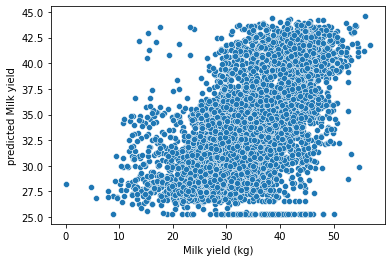

In [9]:
# Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

 # Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol=predictionColName, labelCol=labelColName, metricName="rmse")

 # Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsLR)

print("Root Mean Squared Error: %.2f" % rmse)

# Now let's compute another evaluation metric for our test dataset
r2 = regEval.evaluate(predictionsLR, {regEval.metricName: "r2"})

print("r2: {0:.2f}".format(r2))
sns.scatterplot(x=labelColName, y=predictionColName, data=predictionsLR.toPandas())